# Degrading the data

What happens when we lower the retirement limit of a galaxy? Can we still recover meaningful spiral arms?

This is the question we explore in this chapter: we take our 47 classifications and obtain samples of ten

In [40]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import groupPolylines
import pcaSpiralExtract
import json

In [3]:
with open('classification-dump.json') as f: classifications = json.load(f)
with open('subject-dump.json') as f: subjects = json.load(f)
# print(json.dumps(list(cls[0]['links']['subjects']), indent=1))
index, _ = (next(iter(filter(
    lambda s: s[1] == '6ee8db8f-2a1e-4d10-bcb9-1e5ec84f8f10',
    ((i, list(s['locations'][0].items())[0][1].split('/')[-1].split('.')[0]) for i, s in enumerate(subjects))
))))

subjectId = subjects[index]['id']

classificationsOfSubject = list(filter(lambda c: c['links']['subjects'][0] == subjectId, classifications))
annotations = [c['annotations'] for c in classificationsOfSubject]
annotationsWithSpiral = [c[3]['value'][0]['value'] for c in annotations if len(c[3]['value'][0]['value'])]
spirals = [[a['points'] for a in c] for c in annotationsWithSpiral]
spiralsWithLengthCut = [
    [[[p['x'], p['y']] for p in a] for a in c]
    for c in spirals if all([len(a) > 5 for a in c])
]
drawnArms = np.array([np.array(arm) for classification in spiralsWithLengthCut for arm in classification])

In [6]:
np.random.seed(0)
classificationGroups = [np.random.choice(np.arange(len(annotations)), size=30, replace=False) for i in range(5)]
classificationGroups

[array([28, 33, 30,  4, 18, 11, 42, 31, 22, 10, 27, 32, 29, 43,  2, 45, 26,
        15, 25, 16, 40, 20, 41,  8, 13,  5, 17, 34, 14, 37]),
 array([21, 30, 33, 37,  2, 16, 29, 20,  8, 38, 22, 19, 13, 44, 26, 41, 24,
        46, 12, 27, 42, 39, 18, 14, 43, 45,  6,  3, 25,  9]),
 array([33, 12,  7, 15, 40, 27, 39, 20, 25,  8,  6, 16,  4,  1, 43, 44, 19,
        17, 32, 14, 28, 22, 37, 24,  2, 23, 26, 11, 18, 10]),
 array([17, 15,  7, 32, 10, 46, 36, 25, 33, 39,  1, 35,  5,  6,  9, 28, 18,
        27, 16, 22, 21, 23, 11, 38, 29,  4,  0, 14, 12, 41]),
 array([21, 14, 36, 30, 26,  4, 35, 16, 45,  9, 25, 17,  2, 19, 27, 46, 23,
        20, 28,  8, 33,  0, 38,  5, 22, 37,  6, 12, 10, 32])]

Working on group 1
	Plotting classifications...
	Clustering arms...
1 of 2: Calculating distance matrix...
2 of 2: Running DBSCAN
Estimated number of clusters: 2
	Working on arm label 0
(12, 2) (6, 2)
[[142.  172.5]
 [131.8 168.5]
 [238.9 268.7]
 [120.9 164. ]
 [224.6 216.8]
 [146.5 217.9]
 [249.  273.5]
 [123.3 183.8]
 [115.1 177.9]
 [249.8 211.5]
 [136.5 157.5]
 [230.  254.5]
 [280.8 229.5]
 [144.6 157.8]
 [229.3 247.8]
 [233.9 223.7]
 [251.8 214.5]
 [130.  167.5]]
Dropping 9 sticks
	Working on arm label 1
(8, 2) (6, 2)
[[370.  373.5]
 [362.2 371. ]
 [369.3 383. ]
 [372.6 344.8]
 [328.3 401.5]
 [271.5 248.6]
 [378.3 355.8]
 [273.  256. ]
 [260.  242.5]
 [293.6 268.7]
 [260.9 248.9]
 [168.  336. ]
 [268.3 242.8]
 [380.  310.3]]
Dropping 7 sticks
Working on group 2
	Plotting classifications...
	Clustering arms...
1 of 2: Calculating distance matrix...
2 of 2: Running DBSCAN
Estimated number of clusters: 3
	Working on arm label 0
(8, 2) (5, 2)
[[271.5 248.6]
 [378.3 355.8]
 [273.  256. 

AttributeError: 'bool' object has no attribute 'shape'

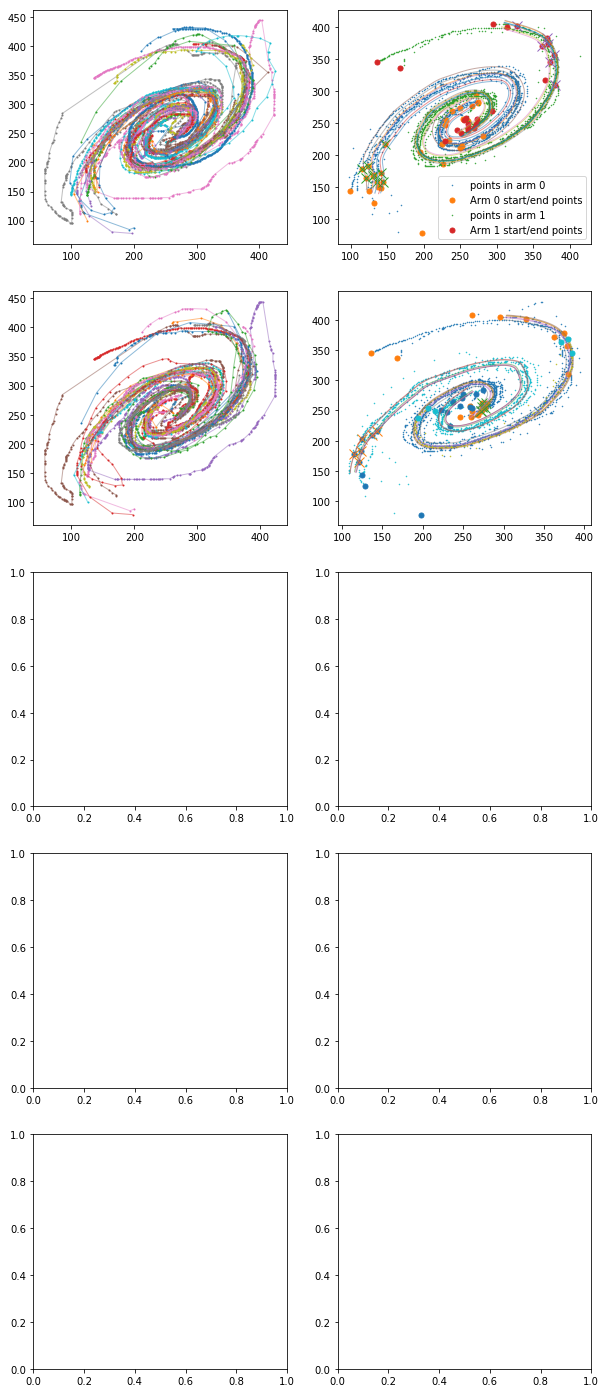

In [11]:
fig, ax = plt.subplots(ncols=2, nrows=len(classificationGroups), figsize=(10, len(classificationGroups)*5))
splineGroups = []
for groupIndex, indices in enumerate(classificationGroups[:]):
    print('Working on group {}'.format(groupIndex + 1))
    filteredAnnotations = [annotations[i] for i in indices]
    annotationsWithSpiral = [c[3]['value'][0]['value'] for c in filteredAnnotations if len(c[3]['value'][0]['value'])]
    spirals = [[a['points'] for a in c] for c in annotationsWithSpiral]
    spiralsWithLengthCut = [
        [[[p['x'], p['y']] for p in a] for a in c]
        for c in spirals if all([len(a) > 5 for a in c])
    ]
    drawnArms = np.array([np.array(arm) for classification in spiralsWithLengthCut for arm in classification])
    print('\tPlotting classifications...')
    for index, arm in enumerate(drawnArms):
        ax[groupIndex][0].plot(arm[:, 0], arm[:, 1], linewidth=1, alpha=0.5, c='C{}'.format(index % 10))
        ax[groupIndex][0].plot(arm[:, 0], arm[:, 1], '.', markersize=2, c='C{}'.format(index % 10))
    splines = []
    
    print('\tClustering arms...')
    db = groupPolylines.clusterPolyLines(drawnArms)
    armLabels = db.labels_
    
    for armLabel in range(np.max(armLabels) + 1):
        print('\tWorking on arm label {}'.format(armLabel))
        pointCloud = np.concatenate(drawnArms[armLabels == armLabel])
        
        ax[groupIndex, 1].plot(pointCloud[:, 0], pointCloud[:, 1], '.', markerSize=1, label='points in arm {}'.format(armLabel))
        startEndPoints = np.array(
            [i[0] for i in drawnArms[armLabels == armLabel]]
            + [i[-1] for i in drawnArms[armLabels == armLabel]]
        )
        ax[groupIndex, 1].plot(
            startEndPoints[:, 0],
            startEndPoints[:, 1],
            'o',
            markerSize=5,
            label='Arm {} start/end points'.format(armLabel)
        )
        
        cleanedCloud, outlierMask = groupPolylines.identifyOutliers(pointCloud)

        vectorField, variances = pcaSpiralExtract.getVectorField(cleanedCloud)
        varianceCutoffMask = variances[:, 0] / variances[:, 1] > 3.0
        cleanedVectorField = vectorField[varianceCutoffMask]

        startCluster = pcaSpiralExtract.getStartCluster(drawnArms[armLabels == armLabel], cleanedCloud)
        if startCluster.shape[0] == 0:
            print('>>>> No start cluster identified')
            continue
        ax[groupIndex, 1].plot(startCluster[:, 0], startCluster[:, 1], 'x', markersize=10)
        paths = pcaSpiralExtract.dropSticks(startCluster, cleanedVectorField)
        for path in paths:
            ax[groupIndex, 1].plot(path[:, 0], path[:, 1], linewidth=1, alpha=0.5)

        downstreamPoints = np.array([p[-1] for p in paths])
        upstreamPoints = np.array([p[0] for p in paths])

        downstreamClusterMask = pcaSpiralExtract.findDownstreamCluster(downstreamPoints)
        if not np.any(downstreamClusterMask):
            print('>>>> No downstream cluster identified')
            continue
        startPoint = (
            np.add.reduce(startCluster[downstreamClusterMask]) /
            startCluster[downstreamClusterMask].shape[0]
        )
        finalPath = pcaSpiralExtract.dropStick(startPoint, cleanedVectorField)
        res = pcaSpiralExtract.sortCloudAlongLine(cleanedCloud, finalPath)
        pointOrder = np.argsort(res[0])

        Sx, Sy = pcaSpiralExtract.fitParametrisedSpline(cleanedCloud[pointOrder]/512)
        splines.append([Sx, Sy])
    ax[groupIndex, 1].legend()
#     splineGroups.append(splines)

Working on group 2
	Plotting classifications...
	Clustering arms...
1 of 2: Calculating distance matrix...
2 of 2: Running DBSCAN
Estimated number of clusters: 3
	Working on arm label 0
(8, 2) (5, 2)
[[271.5 248.6]
 [378.3 355.8]
 [273.  256. ]
 [277.5 253.9]
 [278.7 261.6]
 [362.2 371. ]
 [328.3 401.5]
 [374.3 377.5]
 [380.  310.3]
 [168.  336. ]
 [260.5 407.9]
 [272.9 261.6]
 [272.3 249.5]]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

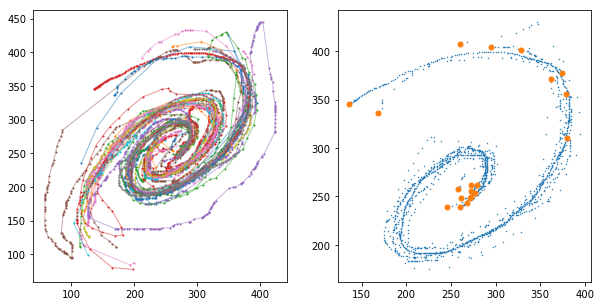

In [18]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))
groupIndex = 1
indices = classificationGroups[1]
print('Working on group {}'.format(groupIndex + 1))
filteredAnnotations = [annotations[i] for i in indices]
annotationsWithSpiral = [c[3]['value'][0]['value'] for c in filteredAnnotations if len(c[3]['value'][0]['value'])]
spirals = [[a['points'] for a in c] for c in annotationsWithSpiral]
spiralsWithLengthCut = [
    [[[p['x'], p['y']] for p in a] for a in c]
    for c in spirals if all([len(a) > 5 for a in c])
]
drawnArms = np.array([np.array(arm) for classification in spiralsWithLengthCut for arm in classification])
print('\tPlotting classifications...')
for index, arm in enumerate(drawnArms):
    ax[0].plot(arm[:, 0], arm[:, 1], linewidth=1, alpha=0.5, c='C{}'.format(index % 10))
    ax[0].plot(arm[:, 0], arm[:, 1], '.', markersize=2, c='C{}'.format(index % 10))
splines = []

print('\tClustering arms...')
armLabels = groupPolylines.clusterPolyLines(drawnArms)

for armLabel in range(np.max(armLabels) + 1):
    print('\tWorking on arm label {}'.format(armLabel))
    pointCloud = np.concatenate(drawnArms[armLabels == armLabel])

    ax[1].plot(pointCloud[:, 0], pointCloud[:, 1], '.', markerSize=1, label='points in arm {}'.format(armLabel))
    startEndPoints = np.array(
        [i[0] for i in drawnArms[armLabels == armLabel]]
        + [i[-1] for i in drawnArms[armLabels == armLabel]]
    )
    ax[1].plot(
        startEndPoints[:, 0],
        startEndPoints[:, 1],
        'o',
        markerSize=5,
        label='Arm {} start/end points'.format(armLabel)
    )

    cleanedCloud, outlierMask = groupPolylines.identifyOutliers(pointCloud)

    vectorField, variances = pcaSpiralExtract.getVectorField(cleanedCloud)
    varianceCutoffMask = variances[:, 0] / variances[:, 1] > 3.0
    cleanedVectorField = vectorField[varianceCutoffMask]

    startCluster = pcaSpiralExtract.getStartCluster(drawnArms[armLabels == armLabel], cleanedCloud)
    
    if (not bool(startCluster)) or startCluster.shape[0] == 0:
        print('>>>> No start cluster identified')
        continue
    ax[1].plot(startCluster[:, 0], startCluster[:, 1], 'x', markersize=10)
    paths = pcaSpiralExtract.dropSticks(startCluster, cleanedVectorField)
    for path in paths:
        ax[1].plot(path[:, 0], path[:, 1], linewidth=1, alpha=0.5)

    downstreamPoints = np.array([p[-1] for p in paths])
    upstreamPoints = np.array([p[0] for p in paths])

    downstreamClusterMask = pcaSpiralExtract.findDownstreamCluster(downstreamPoints)
    if not np.any(downstreamClusterMask):
        print('>>>> No downstream cluster identified')
        continue
    startPoint = (
        np.add.reduce(startCluster[downstreamClusterMask]) /
        startCluster[downstreamClusterMask].shape[0]
    )
    finalPath = pcaSpiralExtract.dropStick(startPoint, cleanedVectorField)
    res = pcaSpiralExtract.sortCloudAlongLine(cleanedCloud, finalPath)
    pointOrder = np.argsort(res[0])

    Sx, Sy = pcaSpiralExtract.fitParametrisedSpline(cleanedCloud[pointOrder]/512)
    splines.append([Sx, Sy])
ax[1].legend()

In [ ]:
list(filter(lambda i: i==2, [1,2,3] ))

In many cases spiral arms are identified (though the following steps of PCA and spline fitting may yet fail due to the low classification counts). However, there are cases where only one arm is properly identified.